# LUNG NODULE IDENTIFICATION

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rawpy
import os
import numpy as np
#import skimage.io as io
import SimpleITK as sltk
import matplotlib.animation as animation
import imageio
import cv2
from IPython.display import Image
import warnings
import multiprocessing
import glob
import random
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
num_cores = multiprocessing.cpu_count()-3
print(num_cores)

9


### Reading Data Files

#### Nodule Annotation File

In [3]:
df1=pd.read_csv('D:/Data Science Bowl 2017/LUNA Dataset/CSVFILES/annotations.csv')
df1.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


#### False Positive Reduction File

In [4]:
df=pd.read_csv('D:/Data Science Bowl 2017/LUNA Dataset/CSVFILES/candidates_V2.csv')
#df.head()

In [5]:
#Dataset is highly imbalanced
df['class'].value_counts()

0    753418
1      1557
Name: class, dtype: int64

#### Sample submission file

In [6]:
df2=pd.read_csv('D:/Data Science Bowl 2017/LUNA Dataset/CSVFILES/sampleSubmission.csv')
#df2.head()

### Pre-processing

GetImageFromArray(): returns a SimpleITK image with origin set to zero, spacing set to one for all dimensions,
and the direction cosine matrix set to identity. Intensity data is copied from the numpy array. In most cases you
will need to set appropriate meta-data values https://simpleitk.github.io/SPIE2018_COURSE/images_and_resampling.pdf

In [7]:
a='D:/Data Science Bowl 2017/LUNA Dataset/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.128881800399702510818644205032.mhd'
b='D:/Data Science Bowl 2017/LUNA Dataset/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd'
c='D:/Data Science Bowl 2017/LUNA Dataset/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd'
nda0=sltk.ReadImage(a)
nda=sltk.GetArrayFromImage(nda0)

#### Resampling image to isometric form

A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)! A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 
<br> -  [1] https://www.kaggle.com/akh64bit/full-preprocessing-tutorial; <br> -  [2] https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

The chest scans are produced by a variety of CT scanners, this causes a difference in spacing between voxels of the original scan. We rescaled and interpolated all CT scans so that each voxel represents a 1x1x1 mm cube. <br> -  [3] https://eliasvansteenkiste.github.io/machine%20learning/lung-cancer-pred/

In [8]:
def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.0), is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [int(np.round(original_size[0]*(original_spacing[0]/out_spacing[0]))),
                int(np.round(original_size[1]*(original_spacing[1]/out_spacing[1]))),
                int(np.round(original_size[2]*(original_spacing[2]/out_spacing[2])))]

    resample = sltk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sltk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sltk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sltk.sitkBSpline)

    return resample.Execute(itk_image)

In [9]:
#img_T1_255 = sltk.Cast(sltk.RescaleIntensity(img_T1), sltk.sitkFloat32)

In [10]:
img_T1=resample_image(sltk.ReadImage(a,sltk.sitkFloat32))
#img_T1_255 = sltk.Cast(sltk.RescaleIntensity(img_T1), sltk.sitkFloat32)
#img_T1 = sltk.ConnectedThreshold(img_T1, seedList=[(100,210,100)], lower=300, upper=40000)
#img=sltk.GetArrayFromImage(img)
#img_T1 = sltk.BinaryThreshold(img_T1, lowerThreshold=-950, upperThreshold=-50, insideValue=1, outsideValue=0)
#feature_img = sitk.GradientMagnitudeRecursiveGaussian(img_T1, sigma=1.5)
#ws_img = sitk.MorphologicalWatershed(feature_img, level=4, markWatershedLine=False, fullyConnected=False)
#myshow(sitk.LabelToRGB(ws_img), "Watershed Over Segmentation")
#seg = sitk.ConnectedComponent(ws_img!=ws_img[0,0])
#myshow(sitk.LabelOverlay(img, seg), "Foreground Components")

#img=sltk.GetArrayFromImage(img_T1)

In [11]:
#Full
img=resample_image(sltk.ReadImage(a,sltk.sitkFloat32))
#img_T1_255 = sltk.Cast(sltk.RescaleIntensity(img_T1), sltk.sitkFloat32)
#img = img_T1 > 300
#img=sltk.GetArrayFromImage(img)
#seg = sltk.BinaryThreshold(img_T1, lowerThreshold=-950, upperThreshold=-50, insideValue=1, outsideValue=0)
img=sltk.GetArrayFromImage(img)

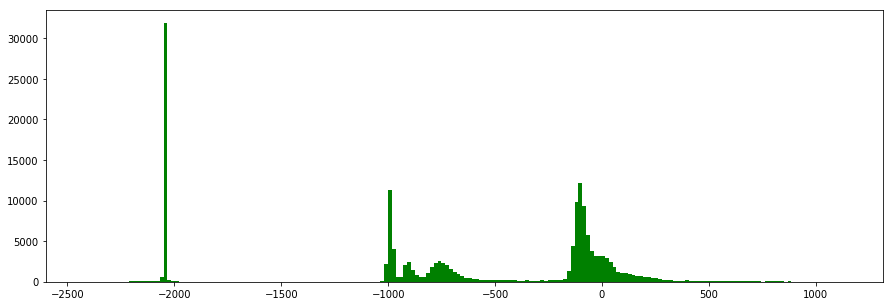

In [12]:
plt.figure(figsize=(15,5))
plt.hist(img[190].flatten(),bins=200,color='green')
plt.show()

In [13]:
#Bones Only
img_b=resample_image(sltk.ReadImage(a))
img_b=sltk.GetArrayFromImage(img_b)
img_min=np.min(img_b)
img_b[img_b<300]=img_min

In [14]:
#Water and Blood
img_wb=resample_image(sltk.ReadImage(a))
#img_wb = sltk.BinaryThreshold(img_wb, lowerThreshold=-950, upperThreshold=-50, insideValue=1, outsideValue=0)
img_wb=sltk.GetArrayFromImage(img_wb)
img_min=np.min(img_wb)
img_wb[img_wb<-100]=img_min
img_wb[img_wb>300]=img_min

In [15]:
# Lung Tissues
img_lt=resample_image(sltk.ReadImage(a))
#img_lt = sltk.BinaryThreshold(img_lt, lowerThreshold=-600, upperThreshold=-100, insideValue=1, outsideValue=0)
#img_lt=sltk.GetArrayFromImage(img_lt)
img_lt=sltk.GetArrayFromImage(img_lt)
img_min=np.min(img_lt)
img_lt[img_lt<-990]=img_min
img_lt[img_lt>-250]=img_min

In [16]:
#Air
img_a=resample_image(sltk.ReadImage(a))
img_a=sltk.GetArrayFromImage(img_a)
img_min=np.min(img_lt)
img_a[img_a>-990]=img_min

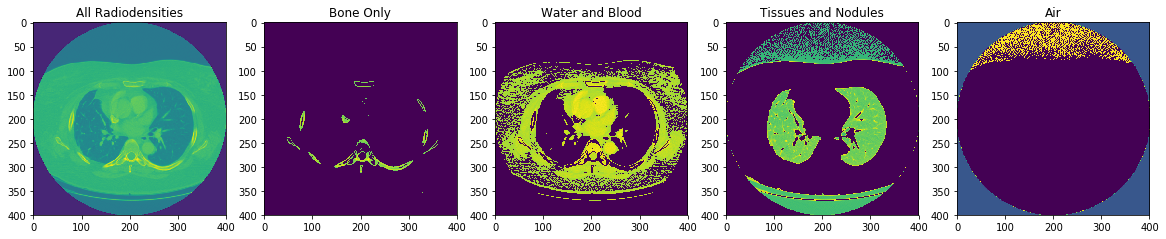

In [17]:
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(151)
ax.imshow(img[190])
ax.title.set_text('All Radiodensities')

ax = fig.add_subplot(152)
ax.imshow(img_b[190])
ax.title.set_text('Bone Only')

ax = fig.add_subplot(153)
ax.imshow(img_wb[190])
ax.title.set_text('Water and Blood')

ax = fig.add_subplot(154)
ax.imshow(img_lt[190])
ax.title.set_text('Tissues and Nodules')

ax = fig.add_subplot(155)
ax.imshow(img_a[190])
ax.title.set_text('Air')

### Generate Binary Mask and Crop Region of Interest

In [18]:
#Create a list of all CT scans in a folder
L=[]
for i in range(0,10):
    M=[]
    M=glob.glob('D:/Data Science Bowl 2017/LUNA Dataset/subset'+str(i)+'/subset'+str(i)+'/*.mhd')
    L=L+M
len(L)

888

In [19]:
train_data=L[0:830]
len(train_data)

830

#### Remove scans that have too many nodules as the tensor runs out of memory

In [20]:
new_train_data=[]
number_nodules=[]
for i in range(0,len(train_data)):
    a=train_data[i].split('\\')[len(train_data[i].split('\\'))-1][:-4]
    sub_loop=len(df1[df1['seriesuid']==a])
    
    if (sub_loop<7):
        number_nodules.append(sub_loop)
        new_train_data.append(train_data[i])

In [21]:
len(new_train_data)

820

In [22]:
valid_data=L[830:850]
len(valid_data)

20

In [23]:
slice_size=64
number_of_slices_per_scan=12
batch_size=1
v_batch_size=1

#### Function to convert images to arrays, generate related mask, and split scans into smaller slices

In [24]:
def load_images(file_list,start,end,size_split,min_slices_per_batch):
    
    '''
    file_list represent the list of the location of files on the drive
    start - represents the start index of picking the files from the file list
    end - represents the end index of picking the files from the file list
    split_size - represents the size of slices to be carved out of image
    min_slides_per_scan - represents the minimum slices of the image to be included in training; first slice with lung nodules are included and the remaining slices are filled with empty slices
    '''
    
    cropped_mask=[]
    cropped_image=[]
    
    for i in range(start,end):
        a=file_list[i].split('\\')[len(file_list[i].split('\\'))-1][:-4]
        
        nda0=sltk.ReadImage(file_list[i])
        nda1=resample_image(nda0)
        nda=sltk.GetArrayFromImage(nda1)
        
        img_min=np.min(nda)
        nda[nda<-900]=img_min
        nda[nda>-50]=img_min
        
        #nda=(nda-nda.min())/(nda.max()-nda.min())
    
        AA = np.zeros((nda.shape[0],nda.shape[1], nda.shape[2]),dtype=int)
    
        X_org=np.array(nda1.GetOrigin())[0]
        Y_org=np.array(nda1.GetOrigin())[1]
        Z_org=np.array(nda1.GetOrigin())[2]
    
        sub_loop=len(df1[df1['seriesuid']==a])
                
        for w in range(0,sub_loop):
            radius = int(df1[df1['seriesuid']==a]['diameter_mm'].iloc[w]/2)+1
            x0=df1[df1['seriesuid']==a]['coordX'].iloc[w]
            y0=df1[df1['seriesuid']==a]['coordY'].iloc[w]
            z0=df1[df1['seriesuid']==a]['coordZ'].iloc[w]

            v_x0=int(x0-X_org)
            v_y0=int(y0-Y_org)
            v_z0=int(z0-Z_org)
            
            #v_x0=int(x0)
            #v_y0=int(y0)
            #v_z0=int(z0)
            
            
            for x in range(v_z0-radius-1, v_z0+radius+1):
                for y in range(v_y0-radius-1, v_y0+radius+1):
                    for z in range(v_x0-radius-1, v_x0+radius+1):
                        deb = radius - abs(v_z0-x) - abs(v_y0-y) - abs(v_x0-z) 
                        if (deb)>=0:
                            AA[x,y,z] = int(1)
            
        zzz=(size_split//2+1,size_split//2+1)
        yyy=(size_split//2+1,size_split//2+1)
        xxx=(size_split//2+1,size_split//2+1)
        npad = (zzz,yyy,xxx)
            
        padded_mask = np.pad(AA, pad_width=npad, mode='constant', constant_values=int(0))
        padded_array =np.pad(nda, pad_width=npad,mode='constant',constant_values=-2047)
        
        count_captured_image=0
        #Crop region of interest
        for w in range(0,sub_loop):
            radius = int(df1[df1['seriesuid']==a]['diameter_mm'].iloc[w]/2)
            x0=df1[df1['seriesuid']==a]['coordX'].iloc[w]
            y0=df1[df1['seriesuid']==a]['coordY'].iloc[w]
            z0=df1[df1['seriesuid']==a]['coordZ'].iloc[w]

            v_x0=int(x0-X_org)+size_split//2+1
            v_y0=int(y0-Y_org)+size_split//2+1
            v_z0=int(z0-Z_org)+size_split//2+1
            
            #I don't know why i did this but it is fixing an error in loading files
            if  not ((abs(v_z0)<size_split//2 and v_z0<0)  or (abs(v_y0)<size_split//2 and v_y0<0) or (abs(v_x0)<size_split//2 and v_x0<0)):
                count_captured_image=count_captured_image+1
                cropped_mask.append(padded_mask[v_z0-size_split//2:v_z0+size_split//2,v_y0-size_split//2:v_y0+size_split//2,v_x0-size_split//2:v_x0+size_split//2])
                cropped_image.append(padded_array[v_z0-size_split//2:v_z0+size_split//2,v_y0-size_split//2:v_y0+size_split//2,v_x0-size_split//2:v_x0+size_split//2])
                                                  
        z_count=nda.shape[0]//size_split
        y_count=nda.shape[1]//size_split
        x_count=nda.shape[2]//size_split
                        
        #Capture some random empty slices from a scan
        if count_captured_image<min_slices_per_batch:
            select_count=(min_slices_per_batch-count_captured_image)//8+1
            z_selected=random.sample(list(range(0,z_count)),select_count)
            y_selected=random.sample(list(range(0,y_count)),select_count)
            x_selected=random.sample(list(range(0,x_count)),select_count)
            
            for ip in range(0,z_count):
                for jp in range(0,y_count):
                    for kp in range(0,x_count):
                        sum_pix=padded_mask[ip*size_split:(ip+1)*size_split,jp*size_split:(jp+1)*size_split,kp*size_split:(kp+1)*size_split].sum()
                        if (ip in z_selected and jp in y_selected and kp in x_selected):
                            cropped_mask.append(AA[ip*size_split:(ip+1)*size_split,jp*size_split:(jp+1)*size_split,kp*size_split:(kp+1)*size_split])
                            cropped_image.append(nda[ip*size_split:(ip+1)*size_split,jp*size_split:(jp+1)*size_split,kp*size_split:(kp+1)*size_split])    
                
        AA=None
        padded_array=None
        nda=None
        nda1=None
        padded_mask=None
        empty_mask=None
        empty_array=None
        nda0=None
    
    return cropped_image,cropped_mask

#### Function to batch generate images and related mask for training

In [25]:
def image_generator(files_path, batch_size,size_split,min_slices_per_batch):

    LUF = len(files_path)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < LUF:
            limit = min(batch_end, LUF)
            X,Y = load_images(files_path,batch_start,limit,size_split,min_slices_per_batch)
            X=np.asarray(X)
            Y=np.asarray(Y)
            data_X=X.reshape(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1)
            data_Y=Y.reshape(Y.shape[0],Y.shape[1],Y.shape[2],Y.shape[3],1)
            
            yield (data_X,data_Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

#### Check visually if the mask reflect the nodules correctly

In [26]:
def valid_viz_data(file_list,start,end,size_split,min_slices_per_batch):
    
    cropped_image,cropped_mask=load_images(file_list,start,end,size_split,min_slices_per_batch)
        
    cropped_image=np.asarray(cropped_image)
    data_X=cropped_image.reshape(cropped_image.shape[0],cropped_image.shape[1],cropped_image.shape[2],cropped_image.shape[3],1)

    cropped_mask=np.asarray(cropped_mask)
    data_Y=cropped_mask.reshape(cropped_mask.shape[0],cropped_mask.shape[1],cropped_mask.shape[2],cropped_mask.shape[3],1)
    
    return data_X,data_Y

In [27]:
X,Y=valid_viz_data(file_list=L,start=830,end=832,size_split=slice_size,min_slices_per_batch=number_of_slices_per_scan)

In [28]:
X.shape

(19, 64, 64, 64, 1)

In [29]:
Y.shape

(19, 64, 64, 64, 1)

In [30]:
def plot_nodules(image_array,mask_array,number_slices):
    
    values=[]
    instance=[]
    for i in range(0,mask_array.shape[0]):
        values.append(mask_array[i].sum())
        instance.append(i)
    df = pd.DataFrame({'instance': instance,'values': values})
    df.sort_values(by=['values'],inplace=True,ascending=False)
    df=df[0:number_slices]
        
    slide_value=[]
    z_temp=[]
    z=[]
    final_sum=[]
    for i in range(0,number_slices):
        df2=None
        for k in range(0,mask_array[df.iloc[i][0]].shape[0]):
            slide_value.append(mask_array[df.iloc[i][0]][k].sum())
            z_temp.append(k)
        
        df2 = pd.DataFrame({'slide_value': slide_value,'z_temp': z_temp})
        df2.sort_values(by=['slide_value'],inplace=True,ascending=False)
        
        z.append(df2.iloc[0][1])
        final_sum.append(mask_array[df.iloc[i][0]][df2.iloc[0][1]].sum())
    
    df['z']=z
    df['final_sum']=final_sum
    
    df=pd.DataFrame({'instance': df['instance'],'z': df['z'],'sum': final_sum})
    
    return df

In [31]:
number_slices_plot=min(16,X.shape[0])
df_p=plot_nodules(image_array=X,mask_array=Y,number_slices=number_slices_plot)

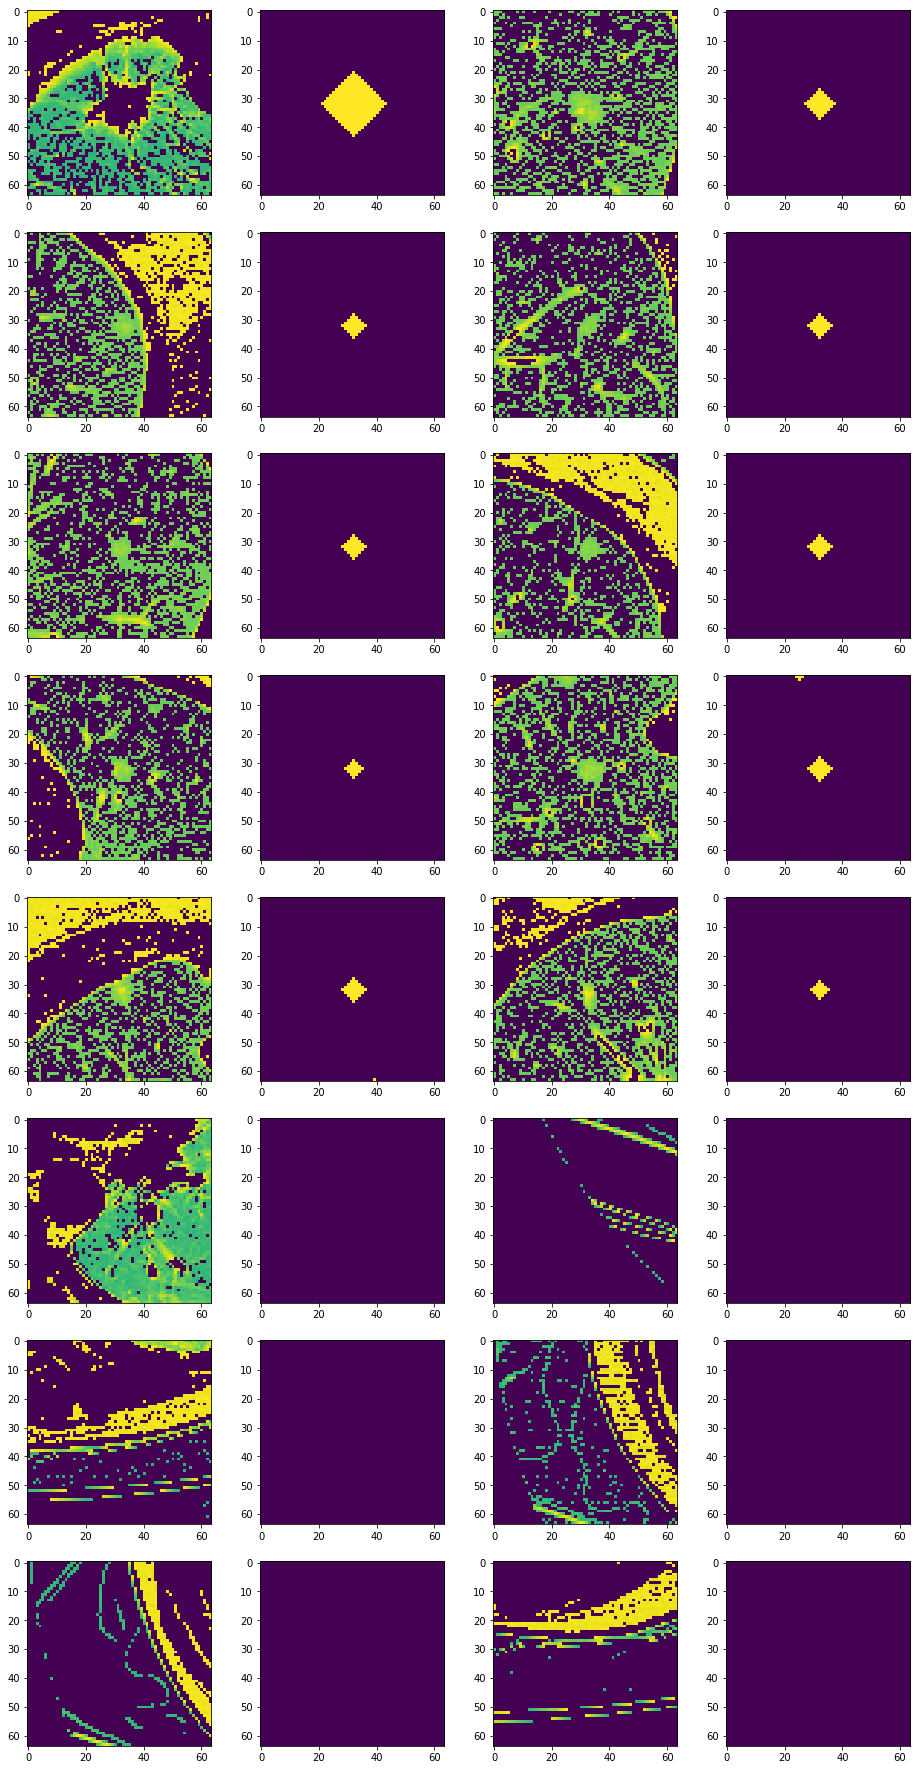

In [32]:
count=0
num_columns=4
num_rows=number_slices_plot*2//num_columns+1

height=num_rows*4
width=num_columns*4

%matplotlib inline
fig = plt.figure(figsize=(width,height))


for i in range(0,number_slices_plot):
    count=count+1
    ax = fig.add_subplot(num_rows,num_columns,count)
    ax.imshow(X[df_p.iloc[i][0]][df_p.iloc[i][2]].reshape(X[df_p.iloc[i][0]][df_p.iloc[i][2]].shape[0],X[df_p.iloc[i][0]][df_p.iloc[i][2]].shape[1]))
    count=count+1
    ax = fig.add_subplot(num_rows,num_columns,count)
    ax.imshow(Y[df_p.iloc[i][0]][df_p.iloc[i][2]].reshape(Y[df_p.iloc[i][0]][df_p.iloc[i][2]].shape[0],Y[df_p.iloc[i][0]][df_p.iloc[i][2]].shape[1]))

## Image Segmentation

In [33]:
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import warnings

#from skimage import measure, morphology
#from skimage.transform import resize

from keras.models import Model
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, merge
from keras.optimizers import Adam
from keras import backend as K
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import SpatialDropout3D
from keras.layers import BatchNormalization
from keras.models import load_model

Using TensorFlow backend.


In [34]:
#Numbers below gets divided everytime we apply maxpooling; this can create issue when concatenating two models
NUM_SLIDES=slice_size
IMG_HEIGHT=slice_size
IMG_WIDTH=slice_size
IMG_CHANNELS=1

In [35]:
def dice_coef(y_true, y_pred):
    smooth = .000000001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.abs(K.sum(y_true_f * y_pred_f))
    return (2. * intersection) / (K.abs(K.sum(y_true_f)) + K.abs(K.sum(y_pred_f)) + smooth)
#Remove smooth from numerator

In [36]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [37]:
def recall_metric(y_true, y_pred):
    smooth = .000000001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.abs(K.sum(y_true_f * y_pred_f))
    recall = (intersection) / (K.abs(K.sum(y_true_f)) + smooth)
    return recall

In [ ]:
# Build U-Net model
inputs = keras.layers.Input((NUM_SLIDES,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = keras.layers.Lambda(lambda x: x / 3095)(inputs)
 
c1 = keras.layers.Conv3D(16, kernel_size=(3,3,3), activation='relu',padding='same')(inputs)
c1 = keras.layers.SpatialDropout3D(0.3)(c1)
c1 = keras.layers.Conv3D(16, (3,3,3), activation='relu',padding='same')(c1)
#GlobalAveragePooling3D -- try this as well
p1 = keras.layers.MaxPooling3D((2,2,2))(c1)
#p1 = BatchNormalization()(p1)
 
c2 = keras.layers.Conv3D(32, (3,3,3), activation='relu',padding='same')(p1)
c2 = keras.layers.SpatialDropout3D(0.3)(c2)
c2 = keras.layers.Conv3D(32, (3,3,3), activation='relu',padding='same')(c2)
p2 = keras.layers.MaxPooling3D((2,2,2))(c2)
#p2 = BatchNormalization()(p2)

c3 = keras.layers.Conv3D(64, (3,3,3), activation='relu',padding='same')(p2)
c3 = keras.layers.SpatialDropout3D(0.3)(c3)
c3 = keras.layers.Conv3D(64, (3,3,3), activation='relu',padding='same')(c3)
p3 = keras.layers.MaxPooling3D((2, 2,2))(c3)
#p3 = BatchNormalization()(p3)

c4 = keras.layers.Conv3D(128, (3,3,3), activation='relu',padding='same')(p3)
c4 = keras.layers.SpatialDropout3D(0.3)(c4)
c4 = keras.layers.Conv3D(128, (3,3,3), activation='relu', padding='same')(c4)
p4 = keras.layers.MaxPooling3D(pool_size=(2,2,2))(c4)
#p4 = BatchNormalization()(p4)

c5 = keras.layers.Conv3D(256, (3,3,3), activation='relu',padding='same')(p4)
c5 = keras.layers.SpatialDropout3D(0.3)(c5)
c5 = keras.layers.Conv3D(256, (3,3,3), activation='relu', padding='same')(c5)
p5 = keras.layers.MaxPooling3D(pool_size=(2,2,2))(c5)
#p5 = BatchNormalization()(p5)


c55 = keras.layers.Conv3D(512, (3,3,3), activation='relu',padding='same')(p5)
c55 = keras.layers.SpatialDropout3D(0.3)(c55)
c55 = keras.layers.Conv3D(512, (3,3,3), activation='relu',padding='same')(c55)
#c55 = BatchNormalization()(c55)


u66 = keras.layers.Conv3DTranspose(256, (2,2,2), strides=(2,2,2), padding='same')(c55)
u66 = keras.layers.concatenate([u66, c5])
c66 = keras.layers.Conv3D(256, (3,3,3), activation='relu',padding='same')(u66)
c66 = keras.layers.SpatialDropout3D(0.3)(c66)
c66 = keras.layers.Conv3D(256, (3,3,3), activation='relu',padding='same')(c66)
#c66 = BatchNormalization()(c66)

u6 = keras.layers.Conv3DTranspose(128, (2,2,2), strides=(2,2,2), padding='same')(c66)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv3D(128, (3,3,3), activation='relu',padding='same')(u6)
c6 = keras.layers.SpatialDropout3D(0.3)(c6)
c6 = keras.layers.Conv3D(128, (3,3,3), activation='relu',padding='same')(c6)
#c6 = BatchNormalization()(c6)

u7 = keras.layers.Conv3DTranspose(64, (2, 2,2), strides=(2, 2,2), padding='same')(c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv3D(64, (3, 3,3), activation='relu',padding='same')(u7)
c7 = keras.layers.SpatialDropout3D(0.3)(c7)
c7 = keras.layers.Conv3D(64, (3, 3,3), activation='relu',padding='same')(c7)
#c7 = BatchNormalization()(c7)

u8 = keras.layers.Conv3DTranspose(32, (2, 2,2), strides=(2, 2,2), padding='same')(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv3D(32, (3, 3,3), activation='relu',padding='same')(u8)
c8 = keras.layers.SpatialDropout3D(0.3)(c8)
c8 = keras.layers.Conv3D(32, (3, 3,3), activation='relu',padding='same')(c8)
#c8 = BatchNormalization()(c8)

u9 = keras.layers.Conv3DTranspose(16, (2, 2,2), strides=(2, 2,2), padding='same')(c8)
u9 = keras.layers.concatenate([u9, c1], axis=4)
c9 = keras.layers.Conv3D(16, (3, 3,3), activation='relu',padding='same')(u9)
c9 = keras.layers.SpatialDropout3D(0.3)(c9)
c9 = keras.layers.Conv3D(16, (3, 3,3), activation='relu',padding='same')(c9)
#c9 = BatchNormalization()(c9)
 
outputs = keras.layers.Conv3D(1, (1, 1,1), activation='sigmoid')(c9)
 
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef,recall_metric])
model.summary()

W0918 02:49:11.154815 75828 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 02:49:11.189728 75828 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 02:49:11.202687 75828 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 02:49:11.231610 75828 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0918 02:49:11.250592 7582

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 64, 64, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout3d_1 (SpatialDro (None, 64, 64, 64, 1 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 64, 64, 1 6928        spatial_dropout3d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('temp_no_normalization_batch.h5', save_weights_only=False)
model.fit_generator(image_generator(files_path=new_train_data,batch_size=batch_size,size_split=slice_size,min_slices_per_batch=number_of_slices_per_scan),steps_per_epoch=len(new_train_data)//batch_size,epochs=10,validation_data=image_generator(files_path=valid_data,batch_size=v_batch_size,size_split=slice_size,min_slices_per_batch=number_of_slices_per_scan),validation_steps=len(valid_data)//v_batch_size,verbose=1,callbacks=[checkpoint])

W0918 02:49:12.876216 75828 deprecation_wrapper.py:119] From C:\Users\thaque2050\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
820/820 [==============================] - 22122s 27s/step - loss: -9.1959e-05 - dice_coef: 9.1959e-05 - recall_metric: 0.0352 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 2/10
820/820 [==============================] - 22106s 27s/step - loss: -2.4257e-05 - dice_coef: 2.4257e-05 - recall_metric: 2.3358e-04 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00 - val_recall_metric: 0.0000e+00
Epoch 3/10
711/820 [=========================>....] - ETA: 48:27 - loss: -1.2746e-05 - dice_coef: 1.2746e-05 - recall_metric: 3.5781e-04

In [ ]:
model.save('NewModel_Tissues.h5')

### Mask Prediction

In [ ]:
#model = load_model('my_model_refined_dice.h5', custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef,'recall_metric':recall_metric})

In [ ]:
test_data=L[850:888]

In [ ]:
def test_generator(files_path, batch_size):

    LUF = len(files_path)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < LUF:
            limit = min(batch_end, LUF)
            X = files_path[batch_start:limit]
            data_X=X.reshape(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1)
            
            yield (data_X)   

            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
def split_image(split_array,z,y,x,split_size):
    cropped_image=[]
    for ip in range(0,z):
        for jp in range(0,y):
            for kp in range(0,x):
                cropped_image.append(split_array[ip*split_size:(ip+1)*split_size,jp*split_size:(jp+1)*split_size,kp*split_size:(kp+1)*split_size])
    
    cropped_image=np.asarray(cropped_image)
    
    return cropped_image

In [ ]:
def combine_image(split_array,z,y,x,split_size):
    AA = np.zeros((z*split_size,y*split_size,x*split_size))
    k=0
    for xu in range(0,z):
        for yu in range(0,y):
            for zu in range(0,x):
                AA[xu*split_size:(xu+1)*split_size,yu*split_size:(yu+1)*split_size,zu*split_size:(zu+1)*split_size]=split_array[k]
                k=k+1
    return AA             

In [ ]:
def predict_generator_fn(test_data,batch_size,split_size):
    
    predicted_mask=[]
    
    for i in range(0,len(test_data)):
        nda0=sltk.ReadImage(test_data[i])
        nda1=resample_image(nda0)
        nda=sltk.GetArrayFromImage(nda1)
        
        img_min=np.min(nda)
        nda[nda<-900]=img_min
        nda[nda>-50]=img_min
        
        z=nda.shape[0]//split_size
        y=nda.shape[1]//split_size
        x=nda.shape[2]//split_size
        
        cropped_image=split_image(nda,z,y,x,split_size)
        
        predict_array = model.predict_generator(test_generator(cropped_image,batch_size),steps = np.ceil(cropped_image.shape[0]/batch_size))
        predict_array=predict_array.reshape(predict_array.shape[0],predict_array.shape[1],predict_array.shape[2],predict_array.shape[3])
        
        temp_mask=combine_image(predict_array,z,y,x,split_size)

        predicted_mask.append(temp_mask)
        
        nda0=None
        nda1=None
        combined_mask=None
        predict_array=None
        cropped_image=None 
        temp_mask=None
        
    return predicted_mask

In [ ]:
Predicted_Mask=predict_generator_fn(test_data=test_data,batch_size=10,split_size=slice_size)

#### Calculate dice coefficient on test dataset

In [ ]:
def generate_test_mask(location,split_size):
    nda0=sltk.ReadImage(location)
    nda1=resample_image(nda0)
    nda=sltk.GetArrayFromImage(nda1)
    
    AA = np.zeros((nda.shape[0],nda.shape[1], nda.shape[2]),dtype=float) #z,y,x
    
    X_org=np.array(nda1.GetOrigin())[0]
    Y_org=np.array(nda1.GetOrigin())[1]
    Z_org=np.array(nda1.GetOrigin())[2]
    
    a=location.split('\\')[len(location.split('\\'))-1][:-4]
    sub_loop=len(df1[df1['seriesuid']==a])
    
    for w in range(0,sub_loop):
        radius = int(df1[df1['seriesuid']==a]['diameter_mm'].iloc[w]/2)
        x0=df1[df1['seriesuid']==a]['coordX'].iloc[w]
        y0=df1[df1['seriesuid']==a]['coordY'].iloc[w]
        z0=df1[df1['seriesuid']==a]['coordZ'].iloc[w]
       
        v_x0=int(x0-X_org)
        v_y0=int(y0-Y_org)
        v_z0=int(z0-Z_org)
            
        for x in range(v_z0-radius-1, v_z0+radius+1):
            for y in range(v_y0-radius-1, v_y0+radius+1):
                for z in range(v_x0-radius-1, v_x0+radius+1):
                    deb = radius - abs(v_z0-x) - abs(v_y0-y) - abs(v_x0-z) 
                    if (deb)>=0:
                        AA[x,y,z] = float(1.0)
    
    nda0=sltk.ReadImage(test_data[i])
    nda1=resample_image(nda0)
    nda=sltk.GetArrayFromImage(nda1)
        
    z=nda.shape[0]//split_size
    y=nda.shape[1]//split_size
    x=nda.shape[2]//split_size
    
    split_mask=split_image(AA,z,y,x,split_size)
    combined_mask=combine_image(split_mask,z,y,x,split_size)
    
    return combined_mask

In [ ]:
#Calculate Dice Coefficient of Prediction
avg_dice_coefficient=[]

for i in range(0,len(Predicted_Mask)):
    y_true=generate_test_mask(test_data[i],split_size=slice_size)
    y_pred=Predicted_Mask[i]
    smooth = .000000001
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.abs((y_true_f * y_pred_f).sum())
    if np.abs(y_true_f.sum())>0:
        avg_dice_coefficient.append((2. * intersection) / (np.abs(y_true_f.sum()) + np.abs(y_pred_f.sum()) + smooth))

In [ ]:
sum(avg_dice_coefficient)/len(avg_dice_coefficient)

#### Visualize predictions!!

In [ ]:
def convert_image_ndarray(location):
    nda0=sltk.ReadImage(location)
    nda1=resample_image(nda0)
    nda=sltk.GetArrayFromImage(nda1)
    return nda

In [ ]:
mask_array=[]
image_arr=[]
predicted_arr=[]
    
for i in range(0,len(test_data)):
    try:
        mask_array.append(generate_test_mask(test_data[i],split_size=slice_size))
        image_arr.append(convert_image_ndarray(test_data[i]))
        predicted_arr.append(Predicted_Mask[i])
                    
    except:
        pass

In [ ]:
number_plots=5
sum_nodules=[]
image_no=[]
    
for i in range(0,len(mask_array)):
    sum_nodules.append(mask_array[i].sum())
    image_no.append(i)
    
df_selected = pd.DataFrame({'a_image_no': image_no,'b_sum_nodules': sum_nodules})
df_selected.sort_values(by=['b_sum_nodules'],inplace=True,ascending=False)
df_selected=df_selected[0:number_plots]

In [ ]:
z=[]
final_sum=[]

for i in range(0,number_plots):
    slide_value=[]
    z_temp=[]
    for k in range(0,mask_array[int(df_selected.iloc[i][0])].shape[0]):
        slide_value.append(mask_array[int(df_selected.iloc[i][0])][k].sum())
        z_temp.append(k)
    
    df2_temp = pd.DataFrame({'slide_value': slide_value,'z_temp': z_temp})  
    df2_temp.sort_values(by=['slide_value'],inplace=True,ascending=False)
        
    z.append(df2_temp.iloc[0][1])
    final_sum.append(mask_array[int(df_selected.iloc[i][0])][int(df2_temp.iloc[0][1])].sum())
    
df_selected['z']=z
df_selected['final_sum']=final_sum

In [ ]:
#Check vizually if the prediction is accurate
num_rows=number_plots
num_cols=3
height=num_rows*6
width=num_cols*6

%matplotlib inline
fig = plt.figure(figsize=(width,height))

count=0

for i in range(0,len(df_selected)):
    count=count+1
    ax = fig.add_subplot(num_rows,num_cols,count)
    #fix the size of the image to match mask and predicted mask!
    ax.imshow(image_arr[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])][0:mask_array[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])].shape[0],0:mask_array[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])].shape[1]])
    
    count=count+1
    ax = fig.add_subplot(num_rows,num_cols,count)
    ax.imshow(mask_array[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])])
    
    count=count+1
    ax = fig.add_subplot(num_rows,num_cols,count)
    ax.imshow(predicted_arr[int(df_selected.iloc[i][0])][int(df_selected.iloc[i][2])])

#### Binary prediction

In [ ]:
import copy

In [ ]:
#Convert predicted mask into binary values with threshold value of less 0.5 as 0 and above as 1
New_Predicted_Mask=copy.deepcopy(Predicted_Mask)

for i in range(0,len(New_Predicted_Mask)):
    New_Predicted_Mask[i][New_Predicted_Mask[i]<0.3]=0
    New_Predicted_Mask[i][New_Predicted_Mask[i]>0.3]=1

In [ ]:
#Calculate Dice Coefficient of Prediction
avg_dice_coefficient=[]

for i in range(0,len(Predicted_Mask)):
    y_true=generate_test_mask(test_data[i],split_size=slice_size)
    y_pred=New_Predicted_Mask[i]
    smooth = .000000001
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.abs((y_true_f * y_pred_f).sum())
    if np.abs(y_true_f.sum())>0:
        avg_dice_coefficient.append((2. * intersection) / (np.abs(y_true_f.sum()) + np.abs(y_pred_f.sum()) + smooth))

In [ ]:
sum(avg_dice_coefficient)/len(avg_dice_coefficient)

### Blob Detection 
Blobs are bright on dark or dark on bright regions in an image. In this example, blobs are detected using 3 algorithms. The image used in this case is the Hubble eXtreme Deep Field. Each bright dot in the image is a star or a galaxy.

Laplacian of Gaussian (LoG)
This is the most accurate and slowest approach. It computes the Laplacian of Gaussian images with successively increasing standard deviation and stacks them up in a cube. Blobs are local maximas in this cube. Detecting larger blobs is especially slower because of larger kernel sizes during convolution. Only bright blobs on dark backgrounds are detected. See skimage.feature.blob_log() for usage.

Difference of Gaussian (DoG)
This is a faster approximation of LoG approach. In this case the image is blurred with increasing standard deviations and the difference between two successively blurred images are stacked up in a cube. This method suffers from the same disadvantage as LoG approach for detecting larger blobs. Blobs are again assumed to be bright on dark. See skimage.feature.blob_dog() for usage.

Determinant of Hessian (DoH)
This is the fastest approach. It detects blobs by finding maximas in the matrix of the Determinant of Hessian of the image. The detection speed is independent of the size of blobs as internally the implementation uses box filters instead of convolutions. Bright on dark as well as dark on bright blobs are detected. The downside is that small blobs (<3px) are not detected accurately. See skimage.feature.blob_doh() for usage.

https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html

In [ ]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
import skimage

In [ ]:
plt.imshow(X[0][18].reshape(X[0][18].shape[0],X[0][18].shape[1]))

In [ ]:
image=X[0][18].reshape(X[0][18].shape[0],X[0][18].shape[1])
#image = data.imread('Img.png')
#image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)


blobs_log2 = skimage.feature.blob_log(image_gray, max_sigma=100, num_sigma=1000, threshold=.1,overlap=.1)
blobs_log2

#blobs = [blobs_log2]
#colors = ['white']
#titles = ['Laplacian of Gaussian (LoG)']
#sequence = zip(blobs, colors, titles)

#for blobs, color, title in sequence:
#    fig, ax = plt.subplots(1, 1)
#    ax.set_title(title)
#    ax.imshow(image, interpolation='nearest')
#    for blob in blobs:
#        y, x, r = blob
#        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
#        ax.add_patch(c)

#plt.show()

In [ ]:
blobs_log2

##### Visualize

### False Positive Reduction

In [ ]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sltk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0]//2, :, :]
    elif nda.ndim == 4:
        c = nda.shape[-1]
        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")
        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]
    xsize = nda.shape[1]
    ysize = nda.shape[0]
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi
    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()
    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)
    t = ax.imshow(nda, extent=extent, interpolation=None)
    if nda.ndim == 2:
        t.set_cmap("gray")
    if(title):
        plt.title(title)
    plt.show()

In [ ]:
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05,dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    img_null = sltk.Image([0, 0], img.GetPixelID(),img.GetNumberOfComponentsPerPixel())
    img_slices = []
    d = 0
    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1
    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1
    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sltk.Tile(img_slices, [maxlen, d])
            # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sltk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sltk.Tile(img_slices_c, [maxlen, d]))
            img = sltk.Compose(img_comps)
    myshow(img, title, margin, dpi)

In [ ]:
myshow3d(img, zslices=range(50, img.GetSize()[2] - 50, 20))